# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.370457
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.520162 analytic: -0.520162, relative error: 4.055234e-08
numerical: -0.374203 analytic: -0.374203, relative error: 1.289959e-07
numerical: -0.044371 analytic: -0.044371, relative error: 9.204709e-07
numerical: -4.897578 analytic: -4.897579, relative error: 2.109596e-08
numerical: -0.128758 analytic: -0.128758, relative error: 1.742977e-07
numerical: 1.238155 analytic: 1.238155, relative error: 2.900003e-08
numerical: -0.918758 analytic: -0.918758, relative error: 6.724948e-09
numerical: 0.397918 analytic: 0.397918, relative error: 1.333153e-07
numerical: 1.265325 analytic: 1.265325, relative error: 1.981951e-08
numerical: -2.440174 analytic: -2.440174, relative error: 5.813369e-09
numerical: -0.167297 analytic: -0.167297, relative error: 2.817834e-08
numerical: 1.858258 analytic: 1.858258, relative error: 1.084368e-08
numerical: -0.350466 analytic: -0.350466, relative error: 3.710019e-08
numerical: 0.158308 analytic: 0.158307, relative error: 2.565543e-07
numerical: -4.84

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.370457e+00 computed in 38.701728s
vectorized loss: 2.370457e+00 computed in 0.017334s
Loss difference: 0.000000
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [8]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 393.185594
iteration 100 / 1500: loss 237.539022
iteration 200 / 1500: loss 144.346773
iteration 300 / 1500: loss 88.025288
iteration 400 / 1500: loss 54.039027
iteration 500 / 1500: loss 33.506175
iteration 600 / 1500: loss 21.095481
iteration 700 / 1500: loss 13.552976
iteration 800 / 1500: loss 8.988114
iteration 900 / 1500: loss 6.214036
iteration 1000 / 1500: loss 4.644543
iteration 1100 / 1500: loss 3.576212
iteration 1200 / 1500: loss 2.954001
iteration 1300 / 1500: loss 2.599004
iteration 1400 / 1500: loss 2.342246
That took 33.627238s


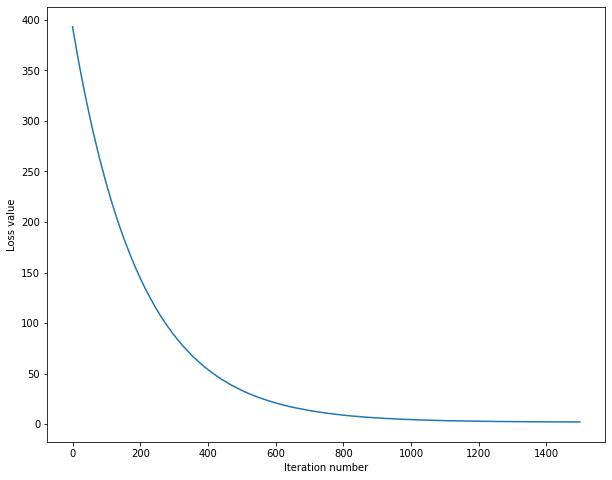

In [9]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [10]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.350653
validation accuracy: 0.363000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
def compute_accuracy(y, y_pred):
    return np.mean(y == y_pred)


for lr in learning_rates:
    for reg in regularization_strengths:
        # train softmax classifier
        print("**********************************")
        print("lr: %.7f, reg: %.1f" %(lr, reg))
        model = Softmax()
        model.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        # compute accuracy
        train_accuracy = compute_accuracy(y_train, model.predict(X_train))
        val_accuracy = compute_accuracy(y_val, model.predict(X_val))

        print('train accuracy: %.4f' %train_accuracy)
        print('validation accuracy: %.4f' %val_accuracy)

        # store accuracy in dictionary
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # check if validation accuracy is best
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

**********************************
lr: 0.0000001, reg: 25000.0
train accuracy: 0.3527
validation accuracy: 0.3570
**********************************
lr: 0.0000001, reg: 50000.0
train accuracy: 0.3324
validation accuracy: 0.3470
**********************************
lr: 0.0000005, reg: 25000.0
train accuracy: 0.3460
validation accuracy: 0.3550
**********************************
lr: 0.0000005, reg: 50000.0
train accuracy: 0.3257
validation accuracy: 0.3390
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.352694 val accuracy: 0.357000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.332449 val accuracy: 0.347000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.345959 val accuracy: 0.355000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.325735 val accuracy: 0.339000
best validation accuracy achieved during cross-validation: 0.357000


In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

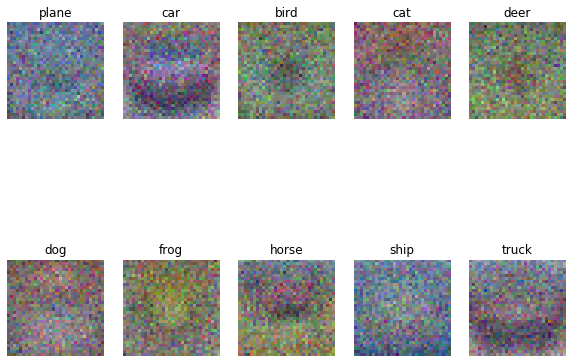

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])